**Package recalling**

In [1]:
# Install necessary packages
!pip install qiskit
!pip install qutip

import numpy as np
import qiskit as qi
import qutip as Q
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics, Input
from tensorflow.keras.utils import plot_model
from sklearn import metrics as sklearn_metrics  # Renamed sklearn's metrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 12.9 MB/s eta 0:00:00


**Data preparetion provisions**

In [2]:
# Set the number of samples
Samples = 500000

# Initialize arrays for entangled and separable states
Entangled = np.empty([Samples, 16], dtype=complex)
Separable = np.empty([Samples, 16], dtype=complex)

# Initialize arrays for labels
ent_label = np.empty([Samples, 2], dtype=float)
sep_label = np.empty([Samples, 2], dtype=float)

**In following you can either download the dataset from Kaggle by runing the first cell or by runing the second cell, generage it.** *(Hingt: genaration takes half an hour or so)*

In [3]:
# Import necessary libraries for file upload and data manipulation
from google.colab import files
import pandas as pd
import numpy as np

# Upload the Kaggle API key (kaggle.json) using the "files" module
files.upload()

# Install the Kaggle library
!pip install -q kaggle

# Create the ~/.kaggle directory and copy the Kaggle API key into it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle using the Kaggle API
!kaggle datasets download -d alikookani/quantangle1

# Create a directory to store the downloaded dataset (e.g., 'train')
!mkdir train

# Unzip the downloaded dataset ('quantangle1.zip') into the 'train' directory
!unzip quantangle1.zip -d train

# Read the data from a CSV file ('mydata.csv') into a Pandas DataFrame
data = pd.read_csv('/content/train/mydata.csv')

# Convert the DataFrame to a NumPy array for further processing
data = np.array(data)


Saving kaggle.json to kaggle.json
 98% 199M/203M [00:06<00:00, 40.8MB/s]
100% 203M/203M [00:06<00:00, 30.6MB/s]
Archive:  quantangle1.zip
  inflating: train/mydata.csv        


In [ ]:
# Start measuring execution time (It takes half an hour or so!)
start = time.time()

# Flags for determining each state's number
i = 0
j = 0

while i < Samples or j < Samples:
    Rho = Q.rand_dm(4, dims=[[2, 2], [2, 2]])
    Density = np.array(Rho)
    temp1 = qi.quantum_info.entanglement_of_formation(Density)

    if temp1 == 0.0 and i < Samples:
        Separable[i, :16] = Density.reshape(1, 16)
        sep_label[i, 0] = temp1
        sep_label[i, 1] = np.linalg.det(Q.partial_transpose(Rho, [0, 1]).full()).real
        i += 1
    elif j < Samples:
        Entangled[j, :16] = Density.reshape(1, 16)
        ent_label[j, 0] = temp1
        ent_label[j, 1] = np.linalg.det(Q.partial_transpose(Rho, [0, 1]).full()).real
        j += 1

# End measuring execution time
end = time.time()
print("Execution time:", end - start)

# Combine data and labels
temp2 = np.concatenate((Separable, sep_label), axis=1)
temp3 = np.concatenate((Entangled, ent_label), axis=1)
data = np.concatenate((temp2, temp3), axis=0)
del temp1, temp2, temp3

**Here we split data into imaginary and complex and turn them into 3D tensor**
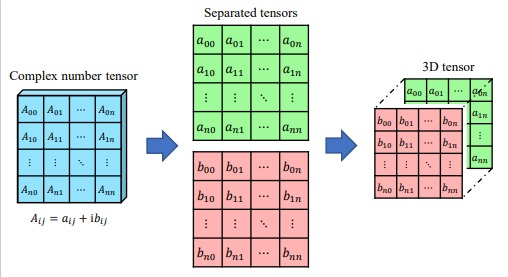

In [4]:
# Separating real and imaginary values
vector = np.empty([len(data), 32], dtype=float)
for i in range(len(data)):
    for j in range(16):
        vector[i, 2 * j] = complex(data[i, j]).real
        vector[i, 2 * j + 1] = complex(data[i, j]).imag
# Reshaping to 3D tensors
matrix = vector.reshape(len(data), 4, 8)
tensor1 = matrix.reshape(len(data), 4, 4, 2)

In [5]:
# Shuffle the dataset
tensor2 = np.empty([len(data), 4, 4, 2], dtype=float)
reg_label = np.empty([len(data)], dtype=float)
class_label = np.ones(len(data)).astype('int')
for i in range(Samples):
    tensor2[2 * i, :, :, :] = tensor1[i, :, :, :]
    reg_label[2 * i] = complex(data[i, 17]).real
    class_label[2 * i] = 0
    tensor2[2 * i + 1, :, :, :] = tensor1[i + Samples, :, :, :]
    reg_label[2 * i + 1] = complex(data[i + Samples, 17]).real

Here we define XpookyNet (Note: For two qubit data we use Conv2D and deactivate BatchNormalization (BN) layers. Moreover, Regression output is temporarily deactivated)
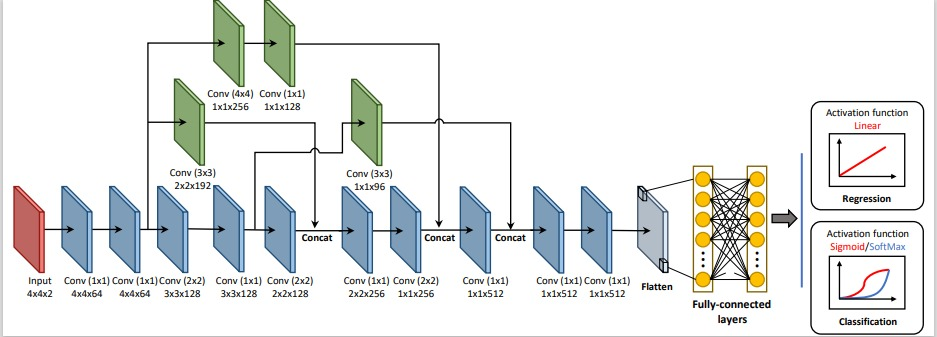

In [6]:
#XpookyNet Model

input_tensor = Input(shape=(4, 4, 2))
layer1 = layers.Conv2D(64, 1)(input_tensor)
#layer1 = layers.BatchNormalization()(layer1)
layer1 = layers.LeakyReLU()(layer1)
layer2 = layers.Conv2D(64, 1)(layer1)
#layer2 = layers.BatchNormalization()(layer2)
layer2 = layers.LeakyReLU()(layer2)
branch_a = layers.Conv2D(256, 4)(layer2)
#branch_a = layers.BatchNormalization()(branch_a)
branch_a = layers.LeakyReLU()(branch_a)
branch_a = layers.Conv2D(128, 1)(branch_a)
#branch_a = layers.BatchNormalization()(branch_a)
branch_a = layers.LeakyReLU()(branch_a)
branch_b = layers.Conv2D(192, 3)(layer2)
#branch_b = layers.BatchNormalization()(branch_b)
branch_b = layers.LeakyReLU()(branch_b)
layer3 = layers.Conv2D(128, 2)(layer2)
#layer3 = layers.BatchNormalization()(layer3)
layer3 = layers.LeakyReLU()(layer3)
layer4 = layers.Conv2D(128, 1)(layer3)
#layer4 = layers.BatchNormalization()(layer4)
layer4 = layers.LeakyReLU()(layer4)
branch_c = layers.Conv2D(96, 3)(layer4)
#branch_c = layers.BatchNormalization()(branch_c)
branch_c = layers.LeakyReLU()(branch_c)
layer5 = layers.Conv2D(128, 2)(layer4)
#layer5 = layers.BatchNormalization()(layer5)
layer5 = layers.LeakyReLU()(layer5)
layer5 = layers.concatenate([layer5, branch_b], axis=-1)
layer6 = layers.Conv2D(256, 1)(layer5)
#layer6 = layers.BatchNormalization()(layer6)
layer6 = layers.LeakyReLU()(layer6)
layer7 = layers.Conv2D(256, 2)(layer6)
#layer7 = layers.BatchNormalization()(layer7)
layer7 = layers.LeakyReLU()(layer7)
layer7 = layers.concatenate([layer7, branch_a], axis=-1)
layer8 = layers.Conv2D(512, 1)(layer7)
#layer8 = layers.BatchNormalization()(layer8)
layer8 = layers.LeakyReLU()(layer8)
layer8 = layers.concatenate([layer8, branch_c], axis=-1)
layer9 = layers.Conv2D(512, 1)(layer8)
#layer9 = layers.BatchNormalization()(layer9)
layer9 = layers.LeakyReLU()(layer9)
layer10 = layers.Conv2D(512, 1)(layer9)
#layer10 = layers.BatchNormalization()(layer10)
layer10 = layers.LeakyReLU()(layer10)
top1 = layers.Flatten()(layer10)
top1 = layers.Dense(512)(top1)
#top1 = layers.BatchNormalization()(top1)
top1 = layers.LeakyReLU()(top1)

#top2 = layers.Dense(1, name='regression')(top1)

top3 = layers.Dense(1)(top1)
#top3 = layers.BatchNormalization()(top3)
top3 = layers.Activation('sigmoid', name='classification')(top3)

#model = models.Model(input_tensor, [top2, top3])
model = models.Model(input_tensor, top3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 4, 2)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 4, 64)     192         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 4, 4, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 4, 4, 64)     4160        ['leaky_re_lu[0][0]']            
                                                                                              

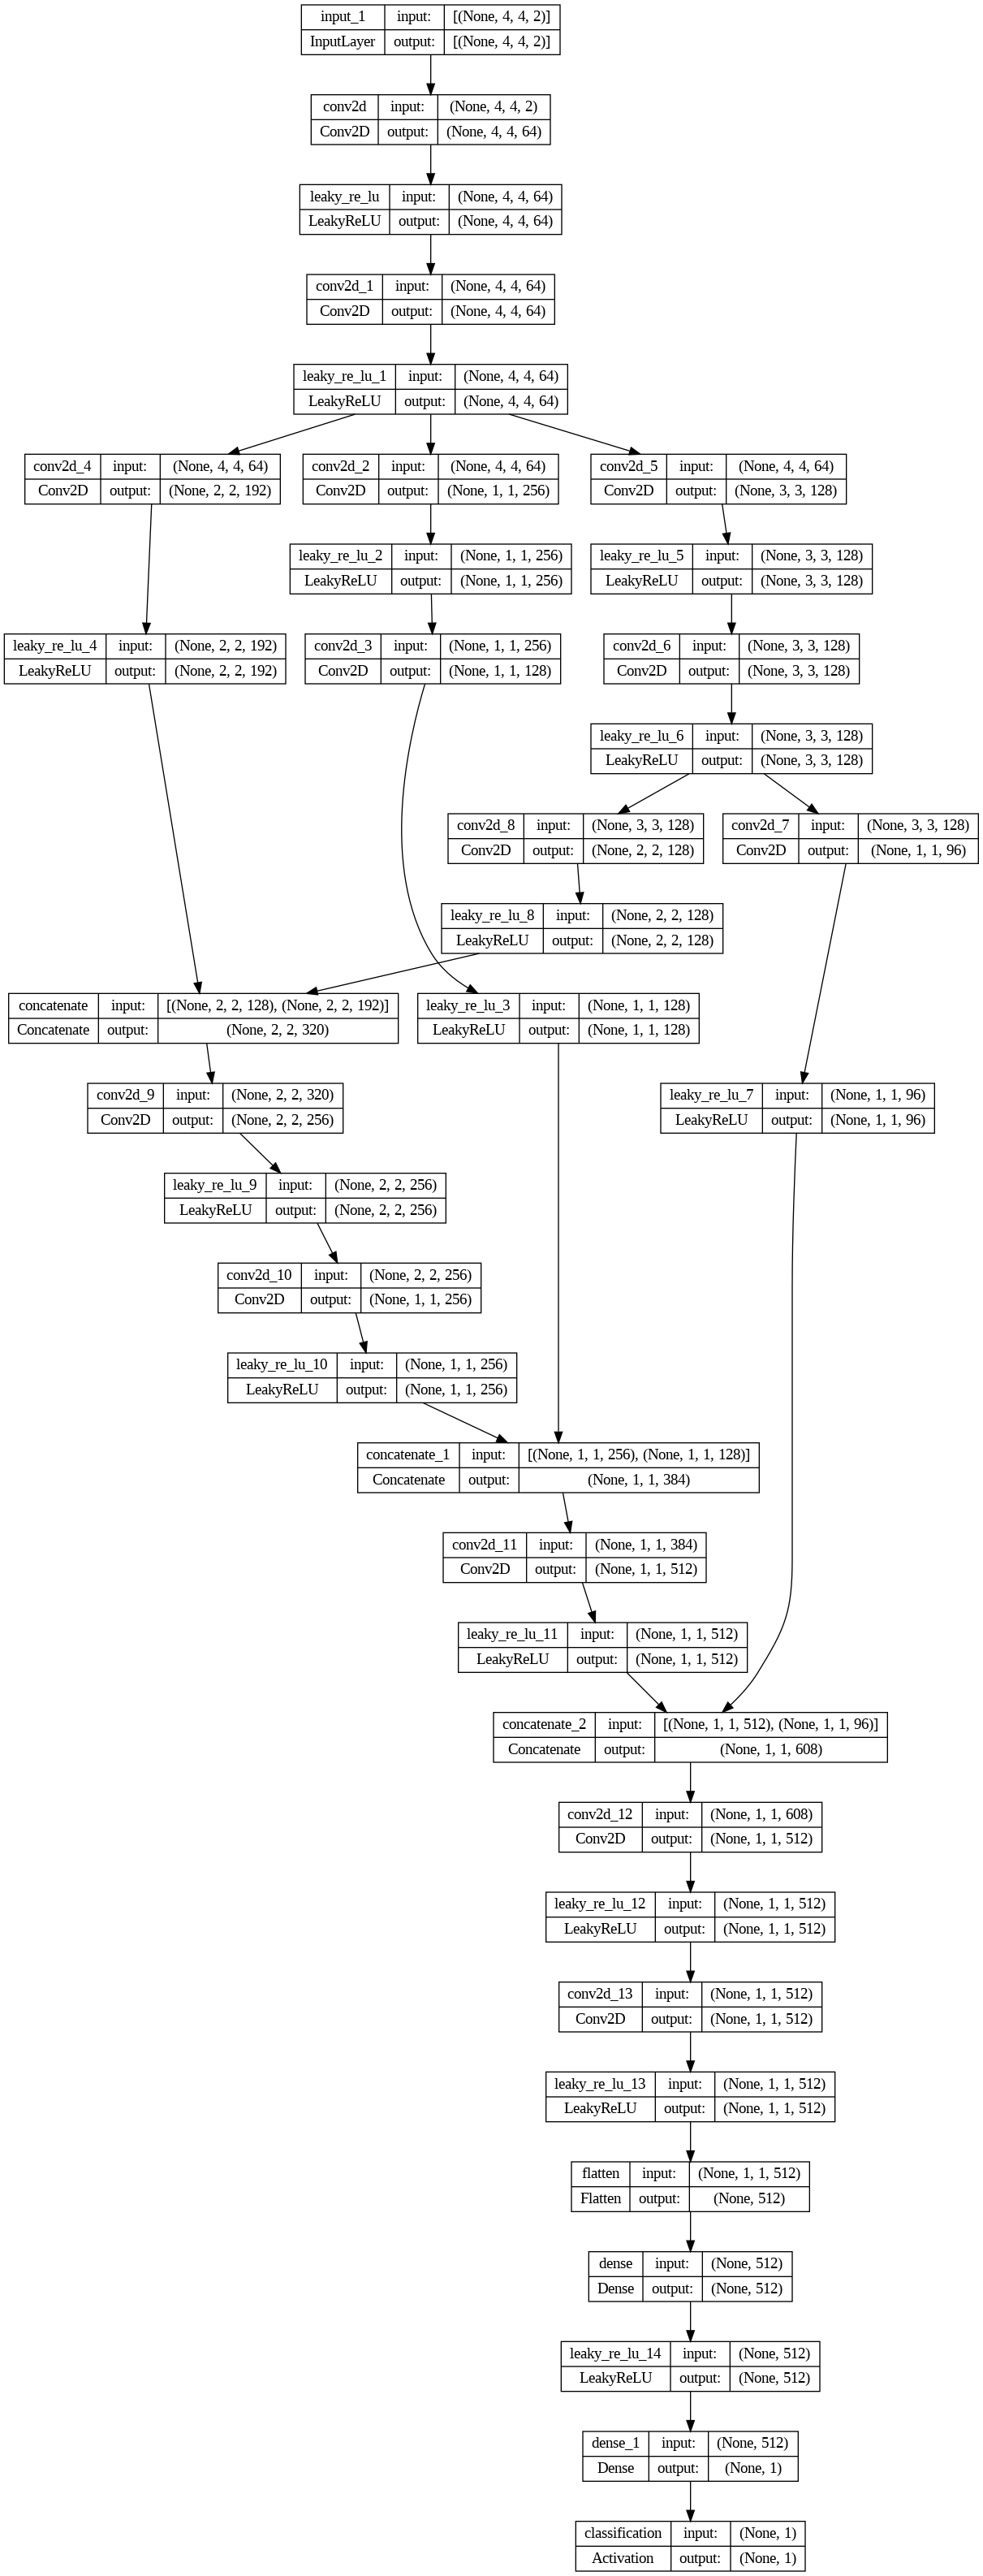

In [7]:
plot_model(model, show_shapes=True, to_file='model.png')

**In three next cells we train the model with multiple learning rate reductions**

In [8]:
# Compile the model
callback_list = [
                 tf.keras.callbacks.ModelCheckpoint(
                     filepath = 'my_model.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 )
]

model.compile(
    optimizer = optimizers.SGD(
        learning_rate = 0.01, momentum = 0.9,
    ),
    loss = {
#        'regression': losses.mse,
        'classification': losses.binary_crossentropy
        },
    metrics = {
#        'regression': metrics.mae,
        'classification': metrics.binary_accuracy
        }
)

history1 = model.fit(
    tensor2[:len(data)-20000, :, :, :],
    {#'regression': reg_label[:len(data)-20000],
     'classification': class_label[:len(data)-20000]},
    batch_size = 125,
    epochs = 8,
    callbacks = callback_list,
    validation_data = (tensor2[len(data)-20000:len(data)-10000, :, :, :],
                     {#'regression': reg_label[len(data)-20000:len(data)-10000],
                      'classification': class_label[len(data)-20000:len(data)-10000]}
                     ),
)

Epoch 1/8
7840/7840 [==============================] - 83s 8ms/step - loss: 0.3179 - binary_accuracy: 0.8474 - val_loss: 0.2036 - val_binary_accuracy: 0.9059
Epoch 2/8
7840/7840 [==============================] - 64s 8ms/step - loss: 0.1598 - binary_accuracy: 0.9299 - val_loss: 0.1223 - val_binary_accuracy: 0.9458
Epoch 3/8
7840/7840 [==============================] - 63s 8ms/step - loss: 0.1197 - binary_accuracy: 0.9479 - val_loss: 0.1105 - val_binary_accuracy: 0.9509
Epoch 4/8
7840/7840 [==============================] - 63s 8ms/step - loss: 0.1038 - binary_accuracy: 0.9550 - val_loss: 0.1093 - val_binary_accuracy: 0.9517
Epoch 5/8
7840/7840 [==============================] - 68s 9ms/step - loss: 0.0933 - binary_accuracy: 0.9597 - val_loss: 0.0974 - val_binary_accuracy: 0.9575
Epoch 6/8
7840/7840 [==============================] - 63s 8ms/step - loss: 0.0866 - binary_accuracy: 0.9625 - val_loss: 0.0837 - val_binary_accuracy: 0.9625
Epoch 7/8
7840/7840 [==============================]

In [9]:
#First manual reduction in learning rate
model.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.001, momentum=0.9,
    ),
    loss = {
#        'regression': losses.mse,
        'classification': losses.binary_crossentropy
        },
    metrics = {
#        'regression': metrics.mae,
        'classification': metrics.binary_accuracy
        }
)

history2 = model.fit(
    tensor2[:len(data)-20000, :, :, :],
    {#'regression': reg_label[:len(data)-20000],
     'classification': class_label[:len(data)-20000]},
    batch_size = 125,
    epochs = 4,
    callbacks = callback_list,
    validation_data = (tensor2[len(data)-20000:len(data)-10000, :, :, :],
                     {#'regression': reg_label[len(data)-20000:len(data)-10000],
                      'classification': class_label[len(data)-20000:len(data)-10000]}
                     ),
)

Epoch 1/4
7840/7840 [==============================] - 78s 10ms/step - loss: 0.0348 - binary_accuracy: 0.9865 - val_loss: 0.0412 - val_binary_accuracy: 0.9830
Epoch 2/4
7840/7840 [==============================] - 67s 9ms/step - loss: 0.0292 - binary_accuracy: 0.9881 - val_loss: 0.0392 - val_binary_accuracy: 0.9836
Epoch 3/4
7840/7840 [==============================] - 63s 8ms/step - loss: 0.0274 - binary_accuracy: 0.9888 - val_loss: 0.0390 - val_binary_accuracy: 0.9841
Epoch 4/4
7840/7840 [==============================] - 65s 8ms/step - loss: 0.0261 - binary_accuracy: 0.9893 - val_loss: 0.0401 - val_binary_accuracy: 0.9831


In [10]:
#Second manual reduction in learning rate
model.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.0001, momentum=0.9,
    ),
    loss = {
#        'regression': losses.mse,
        'classification': losses.binary_crossentropy
        },
    metrics = {
#        'regression': metrics.mae,
        'classification': metrics.binary_accuracy
        }
)

history3 = model.fit(
    tensor2[:len(data)-20000, :, :, :],
    {#'regression': reg_label[:len(data)-20000],
     'classification': class_label[:len(data)-20000]},
    batch_size = 125,
    epochs = 2,
    callbacks = callback_list,
    validation_data = (tensor2[len(data)-20000:len(data)-10000, :, :, :],
                     {#'regression': reg_label[len(data)-20000:len(data)-10000],
                      'classification': class_label[len(data)-20000:len(data)-10000]}
                     ),
)

Epoch 1/2
7840/7840 [==============================] - 66s 8ms/step - loss: 0.0184 - binary_accuracy: 0.9933 - val_loss: 0.0348 - val_binary_accuracy: 0.9854
Epoch 2/2
7840/7840 [==============================] - 63s 8ms/step - loss: 0.0176 - binary_accuracy: 0.9936 - val_loss: 0.0339 - val_binary_accuracy: 0.9866


In [11]:
# Load the best saved model
my_model = tf.keras.models.load_model("my_model.h5")

# Evaluate the model using TensorFlow/Keras metrics
my_model.evaluate(tensor2[len(data)-10000:len(data), :, :, :], {#'regression': reg_label[len(data)-10000:len(data)],
                                                     'classification': class_label[len(data)-10000:len(data)]})

313/313 [==============================] - 2s 5ms/step - loss: 0.0358 - binary_accuracy: 0.9845


[0.03579741343855858, 0.984499990940094]

313/313 [==============================] - 1s 4ms/step


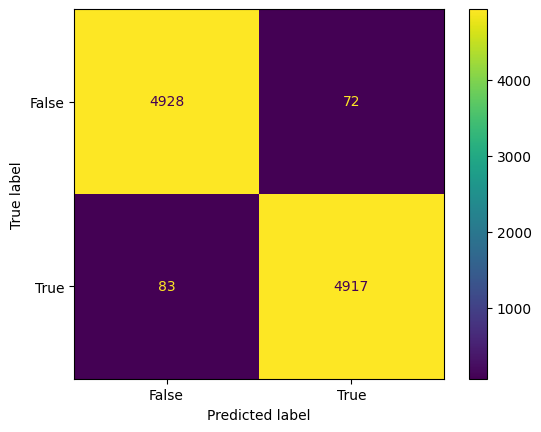

In [12]:
# Make predictions and create a confusion matrix
actual = class_label[990000:1000000]
seq_predictions = my_model.predict(tensor2[990000:1000000, :, :])
seq_predictions = np.transpose(seq_predictions)[0]
seq_predictions = list(map(lambda x: 0 if x < 0.5 else 1, seq_predictions))

# Calculate the confusion matrix using sklearn metrics
confusion_matrix = sklearn_metrics.confusion_matrix(actual, seq_predictions)

# Display the confusion matrix
cm_display = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot()
plt.show()